In [1]:
import nextbike
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error 
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf

In [19]:
dfRaw = nextbike.io.read_file()
dfTrips = nextbike.io.createTrips(dfRaw)
dfTrips = nextbike.io.drop_outliers(dfTrips)
dfTrips.head(2)

,bNumber,sTime,eTime,duration,sLong,sLat,eLong,eLat,weekend,bType,sPlaceNumber,ePlaceNumber,durationInSec
0,11169,2019-01-20 01:55:00,2019-01-20 02:06:00,00:11:00,8.763266,50.795224,8.770358,50.804522,True,15,5173.0,5159.0,660
2,11169,2019-01-20 11:58:00,2019-01-20 12:06:00,00:08:00,8.770358,50.804522,8.759248,50.804725,True,15,5159.0,5178.0,480


In [20]:
dfWeather = nextbike.io.getWeatherData()
dfWeatherMinutes = pd.DataFrame({'date': pd.date_range('2019-01-01', '2020-01-01', freq='min', closed='left')})
dfWeatherMinutes = dfWeatherMinutes.set_index('date')
dfWeatherMinutes = dfWeatherMinutes.join(dfWeather)
dfWeatherMinutes = dfWeatherMinutes.fillna(axis='index', method='ffill')
dfWeatherMinutes

,temperature,precipitation
date,,
2019-01-01 00:00:00,7.6,0.0
2019-01-01 00:01:00,7.6,0.0
2019-01-01 00:02:00,7.6,0.0
2019-01-01 00:03:00,7.6,0.0
2019-01-01 00:04:00,7.6,0.0
...,...,...
2019-12-31 23:55:00,-2.5,0.0
2019-12-31 23:56:00,-2.5,0.0
2019-12-31 23:57:00,-2.5,0.0


In [21]:
dfTrips = dfTrips.join(dfWeatherMinutes, how='left', on='sTime')
dfTrips.head()

,bNumber,sTime,eTime,duration,sLong,sLat,eLong,eLat,weekend,bType,sPlaceNumber,ePlaceNumber,durationInSec,temperature,precipitation
0,11169,2019-01-20 01:55:00,2019-01-20 02:06:00,00:11:00,8.763266,50.795224,8.770358,50.804522,True,15,5173.0,5159.0,660,-10.7,0.0
2,11169,2019-01-20 11:58:00,2019-01-20 12:06:00,00:08:00,8.770358,50.804522,8.759248,50.804725,True,15,5159.0,5178.0,480,-2.2,0.0
3,11169,2019-01-20 15:12:00,2019-01-20 15:27:00,00:15:00,8.759248,50.804725,8.774681,50.822927,True,15,5178.0,5150.0,900,-1.1,0.0
4,11169,2019-01-20 15:39:00,2019-01-20 15:42:00,00:03:00,8.774681,50.822927,8.774681,50.822927,True,15,5150.0,5150.0,180,-1.5,0.0
5,11270,2019-01-20 00:25:00,2019-01-20 00:37:00,00:12:00,8.775948,50.813203,8.775948,50.813203,True,15,5156.0,5156.0,720,-9.7,0.0


In [22]:
dfTrips = dfTrips.drop(columns=['eTime', 'eLong', 'eLat', 'ePlaceNumber','duration'])
dfTrips['sMonth'] = dfTrips['sTime'].dt.month
dfTrips['sDay'] = dfTrips['sTime'].dt.weekday
dfTrips['sHour'] = dfTrips['sTime'].dt.hour
dfTrips['sMinute'] = dfTrips['sTime'].dt.minute


dfTrips.head()

,bNumber,sTime,sLong,sLat,weekend,bType,sPlaceNumber,durationInSec,temperature,precipitation,sMonth,sDay,sHour,sMinute
0,11169,2019-01-20 01:55:00,8.763266,50.795224,True,15,5173.0,660,-10.7,0.0,1,6,1,55
2,11169,2019-01-20 11:58:00,8.770358,50.804522,True,15,5159.0,480,-2.2,0.0,1,6,11,58
3,11169,2019-01-20 15:12:00,8.759248,50.804725,True,15,5178.0,900,-1.1,0.0,1,6,15,12
4,11169,2019-01-20 15:39:00,8.774681,50.822927,True,15,5150.0,180,-1.5,0.0,1,6,15,39
5,11270,2019-01-20 00:25:00,8.775948,50.813203,True,15,5156.0,720,-9.7,0.0,1,6,0,25


In [27]:
dfGroups = dfTrips.resample('h',on='sTime')['durationInSec'].mean().shift(1)
dfGroups


sTime
2019-01-20 00:00:00           NaN
2019-01-20 01:00:00    907.500000
2019-01-20 02:00:00    765.000000
2019-01-20 03:00:00    696.000000
2019-01-20 04:00:00    360.000000
                          ...    
2019-12-31 19:00:00    870.000000
2019-12-31 20:00:00    829.090909
2019-12-31 21:00:00    640.000000
2019-12-31 22:00:00    720.000000
2019-12-31 23:00:00    420.000000
Freq: H, Name: durationInSec, Length: 8304, dtype: float64

In [39]:
allMean = dfTrips['durationInSec'].mean()
dfTrips['autoCorr'] = allMean
for label,content in dfGroups.items():
    dfTrips.loc[dfTrips['sTime'].dt.floor('H') == label,['autoCorr']] = content
dfTrips['autoCorr'].fillna(allMean,inplace=True)

344
1179.4285714285713
974.4
1135.2941176470588
903.3333333333334
1425.6
978.75
933.75
966.0
975.0
1440.0
960.0
793.8461538461538
800.0
765.0
1030.0
1250.0
1035.7894736842106
993.3333333333334
805.7142857142857
845.4545454545455
1063.3333333333333
1192.8
926.6666666666666
1022.8571428571429
1054.8387096774193
835.3846153846154
965.7142857142857
920.0
1038.4615384615386
1066.1538461538462
825.0
795.0
nan
2640.0
1000.0
1260.0
1005.0
831.0
807.5
930.8571428571429
855.0
794.6341463414634
973.0434782608696
863.7931034482758
807.8048780487804
981.1111111111111
869.6103896103896
1073.5714285714287
977.7049180327868
888.6206896551724
1002.5
1137.391304347826
953.0769230769231
857.1428571428571
1260.0
1200.0
980.0
1830.0
795.0
680.0
720.0
1057.7777777777778
699.0697674418604
1031.7391304347825
901.25
980.0
873.5593220338983
1097.3333333333333
919.5918367346939
497.45454545454544
913.448275862069
1012.5925925925926
1042.3529411764705
965.8064516129032
820.0
1037.560975609756
850.7692307692307
82

In [43]:
dfTrips['autoCorr'].fillna(allMean,inplace=True)
dfTrips

,bNumber,sTime,sLong,sLat,weekend,bType,sPlaceNumber,durationInSec,temperature,precipitation,sMonth,sDay,sHour,sMinute,autoCorr
0,11169,2019-01-20 01:55:00,8.763266,50.795224,True,15,5173.0,660,-10.7,0.0,1,6,1,55,907.500000
2,11169,2019-01-20 11:58:00,8.770358,50.804522,True,15,5159.0,480,-2.2,0.0,1,6,11,58,951.428571
3,11169,2019-01-20 15:12:00,8.759248,50.804725,True,15,5178.0,900,-1.1,0.0,1,6,15,12,746.086957
4,11169,2019-01-20 15:39:00,8.774681,50.822927,True,15,5150.0,180,-1.5,0.0,1,6,15,39,746.086957
5,11270,2019-01-20 00:25:00,8.775948,50.813203,True,15,5156.0,720,-9.7,0.0,1,6,0,25,891.705505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
630964,11265,2019-12-31 18:53:00,8.774454,50.824867,False,15,0.0,900,0.3,0.0,12,1,18,53,507.272727
630965,11265,2019-12-31 22:13:00,8.759248,50.804725,False,15,5178.0,540,-0.8,0.0,12,1,22,13,720.000000
630966,11265,2019-12-31 22:37:00,8.775351,50.808070,False,15,5158.0,420,-1.1,0.0,12,1,22,37,720.000000
630967,11080,2019-12-31 12:26:00,8.774508,50.824840,False,15,0.0,960,2.0,0.0,12,1,12,26,930.000000


Hour: 0
Hour: 1
Hour: 2
Hour: 3
Hour: 4
Hour: 5
Hour: 6
Hour: 7
Hour: 8
Hour: 9
Hour: 10
Hour: 11
Hour: 12
Hour: 13
Hour: 14
Hour: 15
Hour: 16
Hour: 17
Hour: 18
Hour: 19
Hour: 20
Hour: 21
Hour: 22
Hour: 23


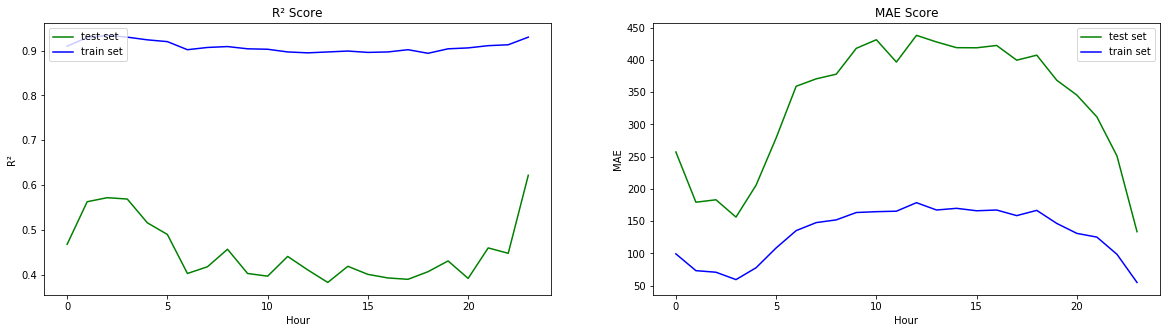

In [52]:

dfTrips.dropna(inplace=True)
dfPred = []
xScaler = []
yScaler = []
X = []
Y = []
r2_train = []
r2_test = []
mae_train = []
mae_test = []
regressor = []
for hour in range(24):
    print('Hour: '+ str(hour))
    dfPred.append(dfTrips.loc[dfTrips['sHour'] == hour])
    X.append(dfPred[hour][['weekend', 'sPlaceNumber','sMinute','temperature','autoCorr']].values)
    Y.append(dfPred[hour]['durationInSec'].values)
    
    x_test, x_train, y_test, y_train = train_test_split(X[hour],Y[hour], test_size=0.3)
    sscaler = StandardScaler()
    x_train = sscaler.fit_transform(x_train)
    x_test = sscaler.transform(x_test)
    xScaler.append(sscaler)
    sscaler2 = StandardScaler()
    
    y_train = sscaler2.fit_transform(y_train.reshape(-1,1))
    y_test = sscaler2.transform(y_test.reshape(-1,1))
    yScaler.append(sscaler2)
    
    #poly_reg = PolynomialFeatures(degree=4)
    #x_test = poly_reg.fit_transform(x_test)
    #x_train = poly_reg.fit_transform(x_train)
    reg = RandomForestRegressor(n_jobs=-1,n_estimators=100)
    #reg = LinearRegression(n_jobs=-1)
    #print(np.isnan(x_train,out=True))
    reg.fit(x_train,y_train)
    r2_train.append(np.round(reg.score(x_train,y_train),3))
    r2_test.append(np.round(reg.score(x_test,y_test),3))
    mae_train.append(np.round(mean_absolute_error(sscaler2.inverse_transform(y_train),sscaler2.inverse_transform(reg.predict(x_train))),3))
    mae_test.append(np.round(mean_absolute_error(sscaler2.inverse_transform(y_test),sscaler2.inverse_transform(reg.predict(x_test))),3))
    #print('R2 Train: ' ,np.round(reg.score(x_train,y_train),3))
    #print('R2 Test: ' , np.round(reg.score(x_test,y_test),3))
    #print('MAE Train: ', np.round(mean_absolute_error(sscaler2.inverse_transform(y_train),sscaler2.inverse_transform(reg.predict(x_train))),3))
    #print('MAE Test: ', np.round(mean_absolute_error(sscaler2.inverse_transform(y_test),sscaler2.inverse_transform(reg.predict(x_test))),3))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(20, 5)
ax1.plot(range(24), r2_test, color='green', label='test set')
ax1.plot(range(24), r2_train, color='blue', label='train set')
ax1.set_title('R² Score')
ax1.legend(loc='upper left')
ax1.set(xlabel='Hour', ylabel='R²')
ax2.plot(range(24), mae_test, color='green', label='test set')
ax2.plot(range(24), mae_train, color='blue', label='train set')
ax2.set_title('MAE Score')
ax2.set(xlabel='Hour', ylabel='MAE')
ax2.legend(loc='upper right')


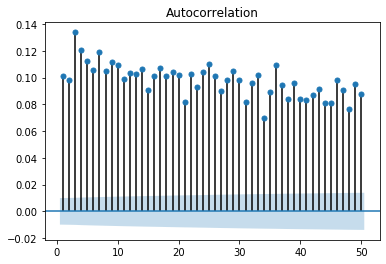

In [14]:
plot_acf(dfTrips.loc[dfTrips['sTime'].dt.hour == 15,['durationInSec']],lags=50,zero=False,unbiased=True)
plt.show()

In [49]:
dfTrips.corr()

,bNumber,sLong,sLat,weekend,bType,sPlaceNumber,durationInSec,temperature,precipitation,sMonth,sDay,sHour,sMinute,autoCorr
bNumber,1.000000,-0.026889,-0.000058,0.009267,0.594560,-0.014016,-0.002048,0.007699,0.001671,-0.003210,0.006808,-0.002500,0.003378,0.001955
sLong,-0.026889,1.000000,-0.000081,-0.009238,-0.014913,-0.011813,-0.001263,0.005805,0.000635,0.008790,-0.008763,-0.000341,0.000019,-0.000172
sLat,-0.000058,-0.000081,1.000000,0.000265,0.000233,-0.013401,-0.000805,0.001117,-0.000504,0.003561,0.001758,-0.000835,0.001798,-0.000202
weekend,0.009267,-0.009238,0.000265,1.000000,0.003460,0.007168,0.008671,0.035364,-0.012175,0.055909,0.764794,-0.006545,0.001096,0.038104
bType,0.594560,-0.014913,0.000233,0.003460,1.000000,-0.015597,0.002639,-0.002854,-0.000586,0.023687,0.004508,0.000807,0.001793,-0.007928
sPlaceNumber,-0.014016,-0.011813,-0.013401,0.007168,-0.015597,1.000000,0.030602,0.007322,-0.003824,-0.067113,0.008523,-0.023570,-0.002246,0.034591
durationInSec,-0.002048,-0.001263,-0.000805,0.008671,0.002639,0.030602,1.000000,0.149163,-0.010815,-0.124959,0.004736,0.023622,-0.017592,0.197459
temperature,0.007699,0.005805,0.001117,0.035364,-0.002854,0.007322,0.149163,1.000000,-0.037522,-0.011252,0.011118,-0.010110,-0.007365,0.324616
precipitation,0.001671,0.000635,-0.000504,-0.012175,-0.000586,-0.003824,-0.010815,-0.037522,1.000000,0.045966,-0.006286,0.021623,0.015807,-0.021851
sMonth,-0.003210,0.008790,0.003561,0.055909,0.023687,-0.067113,-0.124959,-0.011252,0.045966,1.000000,0.065699,0.033596,0.020408,-0.316997


In [23]:
dfTrips['autoCorr'] = dfTrips['durationInSec'].shift(1)

0      NaN
2    660.0
3    480.0
4    900.0
5    180.0
Name: durationInSec, dtype: float64

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_absolute_error 
from sklearn.linear_model import LinearRegression

def plotPerformance (featureList, maxPolyDegree, df, hour):
    
    df = df[df['sHour'] == hour]
    
    polynomialDegrees = [*range(1, maxPolyDegree + 1,1)]
    r2_test = []
    mae_test = []
    r2_train = []
    mae_train = []

    for polynomialDegree in polynomialDegrees:

        X = df[featureList].values
        Y = df[['duration']].values

        x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

        poly_reg = PolynomialFeatures (degree = polynomialDegree)
        x_poly = poly_reg.fit_transform(x_train)

        model = LinearRegression(normalize = True, n_jobs=-1)
        model.fit(x_poly, y_train)

        y_pred_test = model.predict(poly_reg.fit_transform(x_test))
        y_pred_train = model.predict(poly_reg.fit_transform(x_train))
        r2_test.append(r2_score(y_test, y_pred_test))
        r2_train.append(r2_score(y_train, y_pred_train))
        mae_test.append(mean_absolute_error(y_test, y_pred_test))
        mae_train.append(mean_absolute_error(y_train, y_pred_train))

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(20, 5)
    ax1.plot([*range(1, maxPolyDegree + 1,1)], r2_test, color='green', label='test set')
    ax1.plot([*range(1, maxPolyDegree + 1,1)], r2_train, color='blue', label='train set')
    ax1.set_title('R² Score')
    ax1.legend(loc='upper left')
    ax1.set(xlabel='Polynomial Degree', ylabel='R²')
    ax2.plot([*range(1, maxPolyDegree + 1,1)], mae_test, color='green', label='test set')
    ax2.plot([*range(1, maxPolyDegree + 1,1)], mae_train, color='blue', label='train set')
    ax2.set_title('MAE Score')
    ax2.set(xlabel='Polynomial Degree', ylabel='MAE')
    ax2.legend(loc='upper right')

    return r2_test, r2_train, mae_test, mae_train

,temperature,precipitation
date,,
2019-01-01 00:00:00,7.6,0.0
2019-01-01 00:01:00,7.6,0.0
2019-01-01 00:02:00,7.6,0.0
2019-01-01 00:03:00,7.6,0.0
2019-01-01 00:04:00,7.6,0.0
...,...,...
2019-12-31 23:55:00,-2.5,0.0
2019-12-31 23:56:00,-2.5,0.0
2019-12-31 23:57:00,-2.5,0.0


,bNumber,sLong,sLat,weekend,bType,sPlaceNumber,durationInSec,sMonth,weekday,minute,autoCorr,temperature,precipitation,sDay,sHour,sMinute
2,11169,8.770358,50.804522,True,15,5159.0,480,1,6,58,660.0,-2.2,0.0,6,11,58
3,11169,8.759248,50.804725,True,15,5178.0,900,1,6,12,480.0,-1.1,0.0,6,15,12
4,11169,8.774681,50.822927,True,15,5150.0,180,1,6,39,900.0,-1.5,0.0,6,15,39
5,11270,8.775948,50.813203,True,15,5156.0,720,1,6,25,180.0,-9.7,0.0,6,0,25
7,11115,8.775308,50.808057,True,15,5158.0,480,1,6,40,720.0,-5.3,0.0,6,9,40


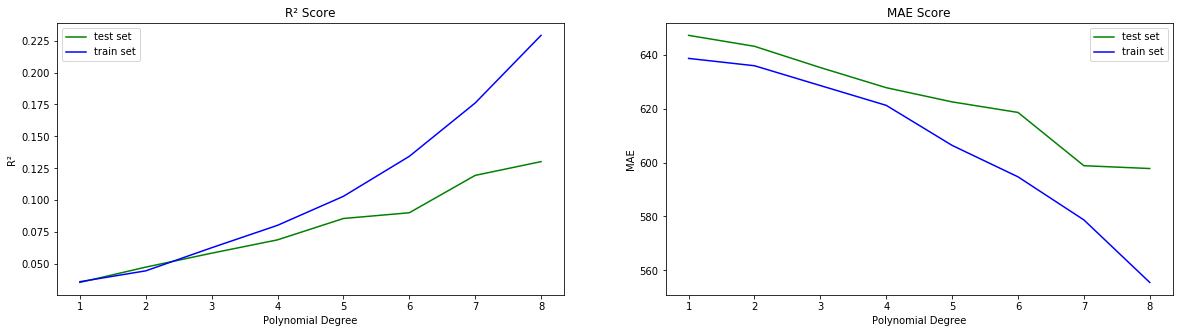

In [18]:
r2_test, r2_train, mae_test, mae_train = plotPerformance(featureList=['sMonth', 'sDay', 'temperature', 'sMinute', 'sPlaceNumber'], maxPolyDegree=8, df=dfTrips, hour=15)